In [1]:
# --- CELL 1: THIẾT LẬP VÀ IMPORT THƯ VIỆN ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings("ignore")

# --- Thư viện cho các mô hình ---
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from neuralforecast.models import NHITS
from neuralforecast.core import NeuralForecast

# Thiết lập style cho biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ Tất cả thư viện đã được import thành công!")

2025-06-11 20:49:28,750	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-11 20:49:29,098	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


✅ Tất cả thư viện đã được import thành công!


In [2]:
# --- CELL 2: ĐỌC VÀ TỔNG HỢP DỮ LIỆU TỪ FILE THÔ (ĐÃ SỬA LỖI) ---

# --- Vui lòng thay đổi các đường dẫn file ở đây ---
raw_file_path = r"C:\Users\nguye\CODE\TimeSeries\BTL\Data\Time_Data.csv"
aggregated_parquet_path = 'aggregated_final_data.parquet'
# ----------------------------------------------------

if os.path.exists(aggregated_parquet_path):
    print(f"Phát hiện file đã tổng hợp '{aggregated_parquet_path}'. Đang đọc trực tiếp...")
    df_agg_final = pd.read_parquet(aggregated_parquet_path)
    print("✅ Đọc file đã tổng hợp thành công!")

else:
    print("Không tìm thấy file đã tổng hợp. Bắt đầu xử lý lại từ file CSV 50GB...")
    chunks = pd.read_csv(raw_file_path, chunksize=10000000)
    all_chunks = []

    print("Bắt đầu tổng hợp dữ liệu theo user_id và tháng...")
    for chunk in tqdm(chunks):
        chunk['event_time'] = pd.to_datetime(chunk['event_time'])
        chunk['month'] = chunk['event_time'].dt.to_period('M').astype(str)
        
        agg = chunk.groupby(['user_id', 'month']).agg(
            event_count=('event_time', 'count'),
            total_spent=('price', 'sum'),
            purchase_count=('event_type', lambda x: (x == 'purchase').sum()),
            n_categories=('category_code', 'nunique'),
            churn=('churn', 'max')
        ).reset_index()
        
        all_chunks.append(agg)

    print("Đang gộp các chunk đã xử lý...")
    df_to_agg = pd.concat(all_chunks)

    # PHẦN SỬA LỖI QUAN TRỌNG NHẤT: Chỉ định rõ cách tổng hợp cho từng cột
    final_aggregation_rules = {
        'event_count': 'sum',
        'total_spent': 'sum',
        'purchase_count': 'sum',
        'n_categories': 'sum',
        'churn': 'max' # Quan trọng: Chỉ lấy giá trị lớn nhất (0 hoặc 1)
    }
    
    df_agg_final = df_to_agg.groupby(['user_id', 'month']).agg(final_aggregation_rules).reset_index()
    
    df_agg_final.to_parquet(aggregated_parquet_path)
    print(f"✅ Dữ liệu đã được tổng hợp ĐÚNG CÁCH và lưu vào '{aggregated_parquet_path}'.")

# Hiển thị kết quả để kiểm tra
print("\n--- 5 DÒNG ĐẦU TIÊN CỦA DỮ LIỆU SAU KHI TỔNG HỢP ---")
print(df_agg_final.head())
print(f"\nKiểm tra các giá trị duy nhất trong cột 'churn' sau khi tổng hợp:")
print(df_agg_final['churn'].unique())

Không tìm thấy file đã tổng hợp. Bắt đầu xử lý lại từ file CSV 50GB...
Bắt đầu tổng hợp dữ liệu theo user_id và tháng...


35it [1:22:18, 141.10s/it]


Đang gộp các chunk đã xử lý...
✅ Dữ liệu đã được tổng hợp ĐÚNG CÁCH và lưu vào 'aggregated_final_data.parquet'.

--- 5 DÒNG ĐẦU TIÊN CỦA DỮ LIỆU SAU KHI TỔNG HỢP ---
    user_id    month  event_count  total_spent  purchase_count  n_categories  \
0  10300217  2019-11            1        40.54               0             0   
1  12511517  2020-02            1       100.39               0             1   
2  12511517  2020-03            1        17.63               0             1   
3  22165363  2020-01            2       507.10               0             2   
4  22165363  2020-02           10       991.38               0             5   

   churn  
0      1  
1      1  
2      1  
3      1  
4      1  

Kiểm tra các giá trị duy nhất trong cột 'churn' sau khi tổng hợp:
[1 0]


In [3]:
# --- CELL 3: TIỀN XỬ LÝ DỮ LIỆU ĐÃ TỔNG HỢP ---

print("Bắt đầu tiền xử lý dữ liệu đã tổng hợp...")
df_processed = df_agg_final.copy()

# 1. Chuyển đổi cột 'month' sang định dạng datetime
df_processed['month'] = pd.to_datetime(df_processed['month'])

# 2. Kiểm tra và xử lý dữ liệu thiếu (nếu có)
print("\nKiểm tra dữ liệu thiếu:")
print(df_processed.isnull().sum())

# 3. Sắp xếp dữ liệu theo user và thời gian
df_processed = df_processed.sort_values(by=['user_id', 'month']).reset_index(drop=True)

print("\n✅ Tiền xử lý hoàn tất. Dữ liệu đã sẵn sàng cho mô hình.")

Bắt đầu tiền xử lý dữ liệu đã tổng hợp...

Kiểm tra dữ liệu thiếu:
user_id           0
month             0
event_count       0
total_spent       0
purchase_count    0
n_categories      0
churn             0
dtype: int64

✅ Tiền xử lý hoàn tất. Dữ liệu đã sẵn sàng cho mô hình.


Bắt đầu trực quan hóa dữ liệu...


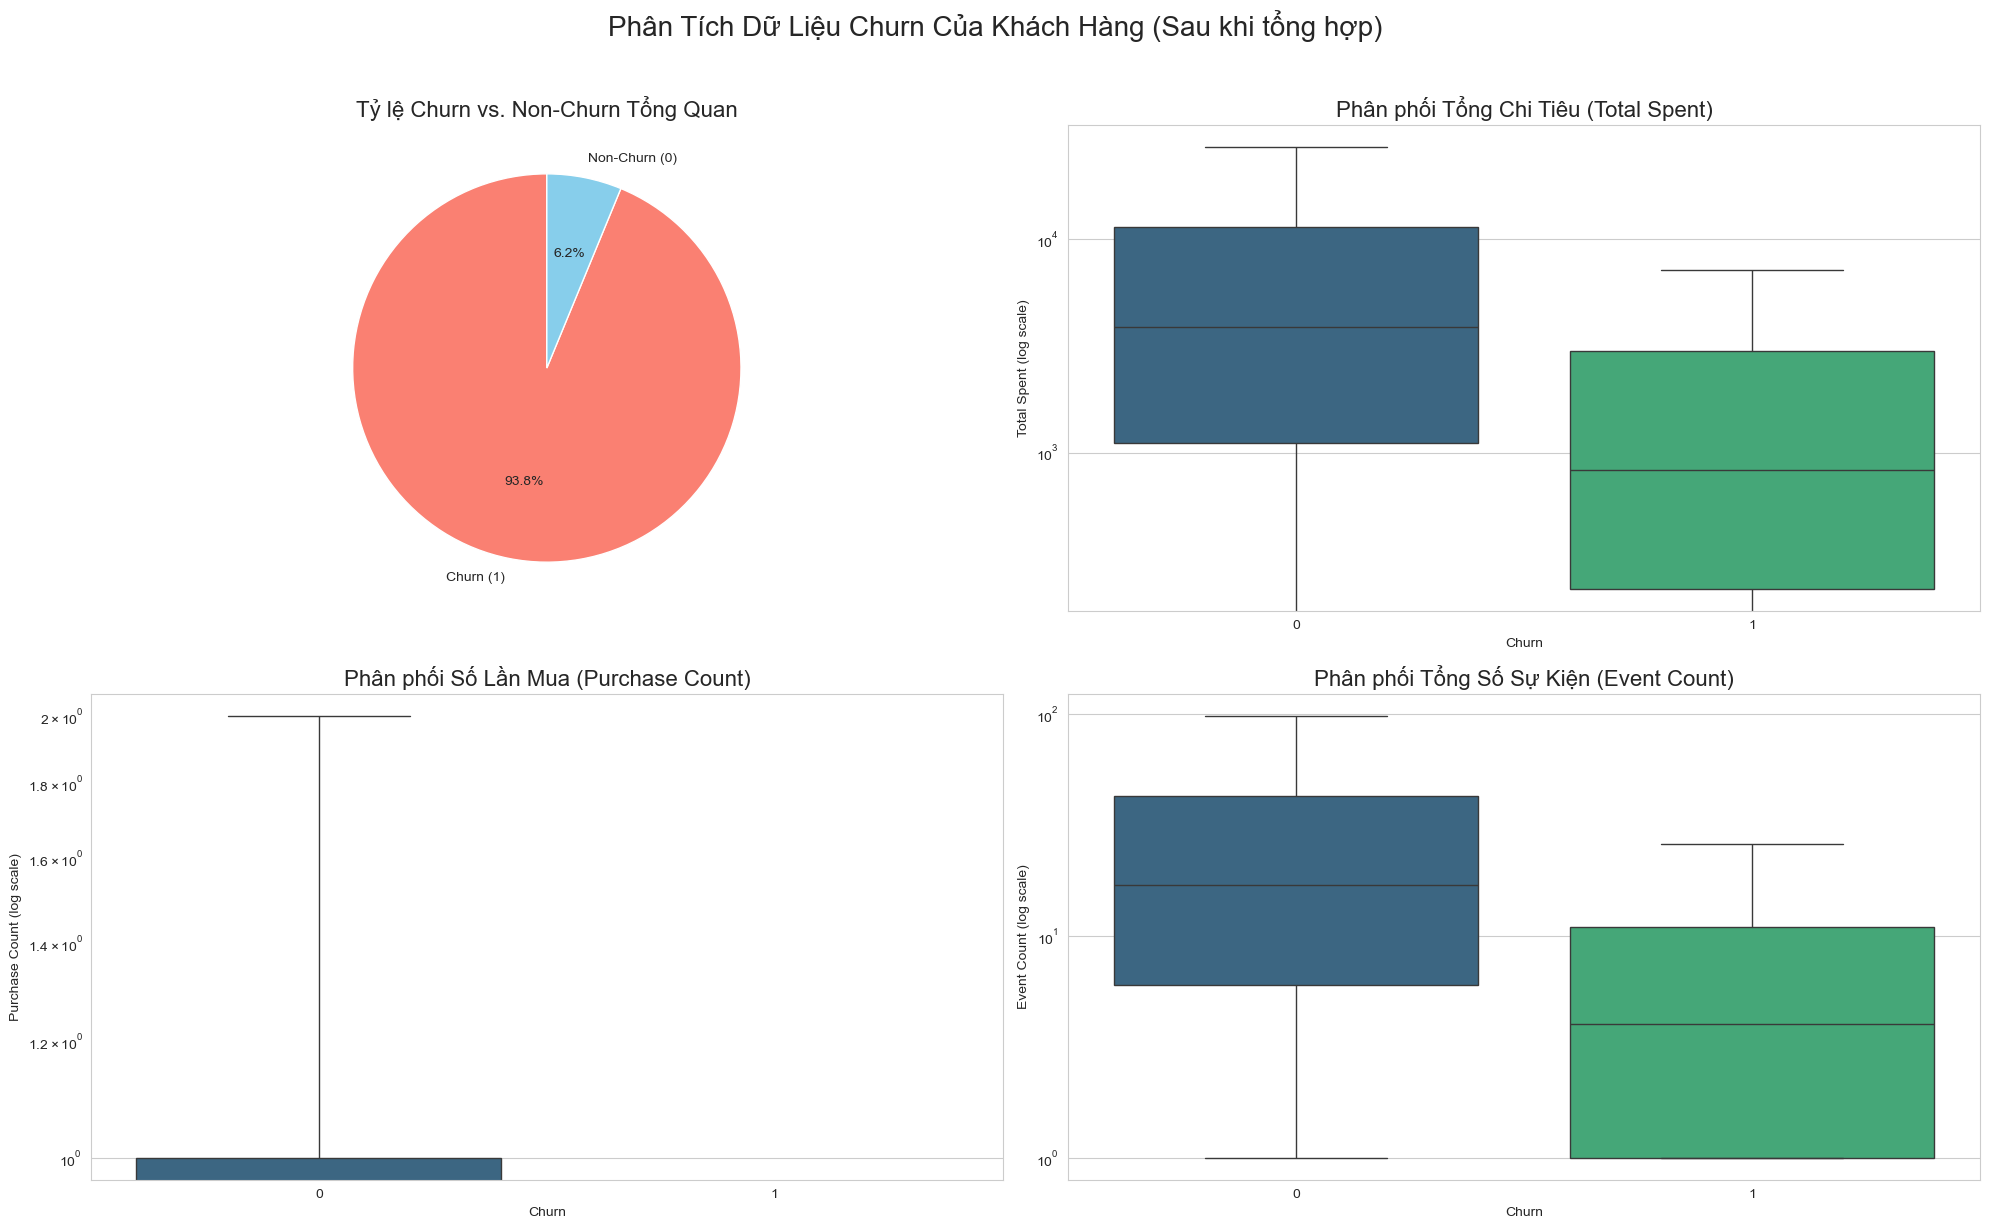

In [4]:
# --- CELL 4: PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU (EDA) (ĐÃ SỬA LỖI) ---

print("Bắt đầu trực quan hóa dữ liệu...")

plt.figure(figsize=(20, 12))
plt.suptitle("Phân Tích Dữ Liệu Churn Của Khách Hàng (Sau khi tổng hợp)", fontsize=20, y=1.02)

# 1. Phân phối của nhãn Churn (Code mới, an toàn hơn)
plt.subplot(2, 2, 1)
churn_counts = df_processed['churn'].value_counts()

# Tạo nhãn và màu sắc động dựa trên dữ liệu thực tế
label_map = {0: 'Non-Churn (0)', 1: 'Churn (1)'}
color_map = {0: 'skyblue', 1: 'salmon'}
dynamic_labels = churn_counts.index.map(lambda x: label_map.get(x, str(x)))
dynamic_colors = churn_counts.index.map(lambda x: color_map.get(x, 'gray'))

if not churn_counts.empty:
    plt.pie(churn_counts, labels=dynamic_labels, colors=dynamic_colors, autopct='%1.1f%%', startangle=90)
    plt.title('Tỷ lệ Churn vs. Non-Churn Tổng Quan', fontsize=16)
else:
    plt.text(0.5, 0.5, 'Không có dữ liệu Churn', ha='center', va='center')
    plt.title('Không có dữ liệu Churn', fontsize=16)
plt.ylabel('')

# 2. Phân phối 'total_spent' theo churn
plt.subplot(2, 2, 2)
sns.boxplot(data=df_processed, x='churn', y='total_spent', showfliers=False, palette='viridis')
plt.title('Phân phối Tổng Chi Tiêu (Total Spent)', fontsize=16)
plt.yscale('log')
plt.xlabel('Churn')
plt.ylabel('Total Spent (log scale)')

# 3. Phân phối 'purchase_count' theo churn
plt.subplot(2, 2, 3)
sns.boxplot(data=df_processed, x='churn', y='purchase_count', showfliers=False, palette='viridis')
plt.title('Phân phối Số Lần Mua (Purchase Count)', fontsize=16)
plt.yscale('log')
plt.xlabel('Churn')
plt.ylabel('Purchase Count (log scale)')

# 4. Phân phối 'event_count' theo churn
plt.subplot(2, 2, 4)
sns.boxplot(data=df_processed, x='churn', y='event_count', showfliers=False, palette='viridis')
plt.title('Phân phối Tổng Số Sự Kiện (Event Count)', fontsize=16)
plt.yscale('log')
plt.xlabel('Churn')
plt.ylabel('Event Count (log scale)')

plt.tight_layout()
plt.show()

In [5]:
# --- CELL 5: CHIA DỮ LIỆU TRAIN/TEST ---

print("Chia dữ liệu theo thời gian...")
last_month = df_processed['month'].max()
print(f"Tháng cuối cùng trong dữ liệu (sẽ được dùng làm tập test): {last_month.strftime('%Y-%m')}")

train_df = df_processed[df_processed['month'] < last_month]
test_df = df_processed[df_processed['month'] == last_month]

features = ['event_count', 'total_spent', 'purchase_count', 'n_categories']
target = 'churn'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"\nKích thước tập huấn luyện (Train): {X_train.shape}")
print(f"Kích thước tập kiểm thử (Test): {X_test.shape}")
if not y_test.empty:
    print(f"Tỷ lệ churn trong tập test: {y_test.value_counts(normalize=True).get(1, 0):.2%}")
else:
    print("CẢNH BÁO: Tập test rỗng, vui lòng kiểm tra lại dữ liệu hoặc logic chia.")

Chia dữ liệu theo thời gian...
Tháng cuối cùng trong dữ liệu (sẽ được dùng làm tập test): 2020-03

Kích thước tập huấn luyện (Train): (19914830, 4)
Kích thước tập kiểm thử (Test): (4114060, 4)
Tỷ lệ churn trong tập test: 94.16%


Bắt đầu huấn luyện mô hình XGBoost...
✅ Huấn luyện XGBoost hoàn tất.

--- 📊 KẾT QUẢ XGBOOST ---
               precision    recall  f1-score   support

Non-Churn (0)       0.14      0.63      0.22    240172
    Churn (1)       0.97      0.75      0.85   3873888

     accuracy                           0.74   4114060
    macro avg       0.55      0.69      0.53   4114060
 weighted avg       0.92      0.74      0.81   4114060

🚀 F1-Score: 0.8469
🚀 ROC AUC Score: 0.7540


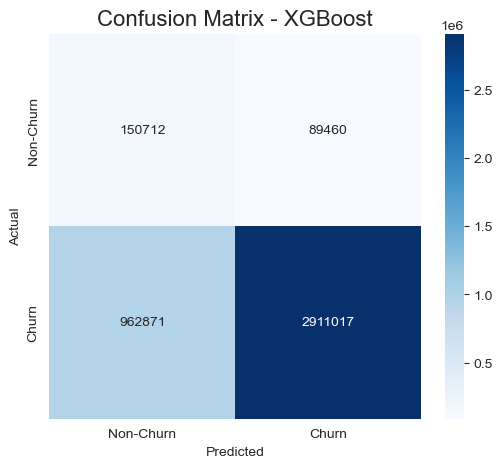

In [6]:
# --- CELL 6: HUẤN LUYỆN VÀ ĐÁNH GIÁ XGBOOST ---

print("Bắt đầu huấn luyện mô hình XGBoost...")

if 1 in y_train.value_counts() and y_train.value_counts()[1] > 0:
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
else:
    ratio = 1 # Trường hợp an toàn nếu không có class 1

xgb_model = XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
    scale_pos_weight=ratio, n_estimators=200, learning_rate=0.05,
    max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42
)

xgb_model.fit(X_train, y_train, verbose=False)
print("✅ Huấn luyện XGBoost hoàn tất.")

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n--- 📊 KẾT QUẢ XGBOOST ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Churn (0)', 'Churn (1)']))
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"🚀 F1-Score: {f1_xgb:.4f}")
print(f"🚀 ROC AUC Score: {roc_auc_xgb:.4f}")

plt.figure(figsize=(6, 5))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.title('Confusion Matrix - XGBoost', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
# --- CELL 7: CHUẨN BỊ DỮ LIỆU DẠNG CHUỖI (SEQUENCE) ---

print("Tạo dữ liệu chuỗi cho các mô hình Deep Learning...")

def create_sequences(df, features, target, sequence_length=3):
    X_seq, y_seq = [], []
    user_groups = df.groupby('user_id')
    
    print("Tạo sequence cho từng user...")
    for user_id, group in tqdm(user_groups):
        data = group[features].values
        labels = group[target].values
        if len(data) > sequence_length:
            for i in range(len(data) - sequence_length):
                X_seq.append(data[i:i+sequence_length])
                y_seq.append(labels[i+sequence_length])
            
    return np.array(X_seq), np.array(y_seq)

SEQUENCE_LENGTH = 3 
X_seq, y_seq = create_sequences(df_processed, features, target, sequence_length=SEQUENCE_LENGTH)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"\n✅ Dữ liệu chuỗi đã tạo xong!")
print(f"Kích thước X_train_seq: {X_train_seq.shape}")
print(f"Kích thước X_test_seq: {X_test_seq.shape}")

Tạo dữ liệu chuỗi cho các mô hình Deep Learning...
Tạo sequence cho từng user...


100%|██████████| 13529831/13529831 [6:50:42<00:00, 549.04it/s]    



✅ Dữ liệu chuỗi đã tạo xong!
Kích thước X_train_seq: (2077704, 3, 4)
Kích thước X_test_seq: (519427, 3, 4)


Bắt đầu huấn luyện LSTM trên thiết bị: CPU...
Epoch [1/5], Loss: 0.3781
Epoch [2/5], Loss: 0.3751
Epoch [3/5], Loss: 0.3733
Epoch [4/5], Loss: 0.3716
Epoch [5/5], Loss: 0.3700

Đánh giá mô hình LSTM...

--- 📊 KẾT QUẢ LSTM ---
               precision    recall  f1-score   support

Non-Churn (0)       0.00      0.00      0.00     66002
    Churn (1)       0.87      1.00      0.93    453425

     accuracy                           0.87    519427
    macro avg       0.44      0.50      0.47    519427
 weighted avg       0.76      0.87      0.81    519427

🚀 F1-Score: 0.9322
🚀 ROC AUC Score: 0.6596


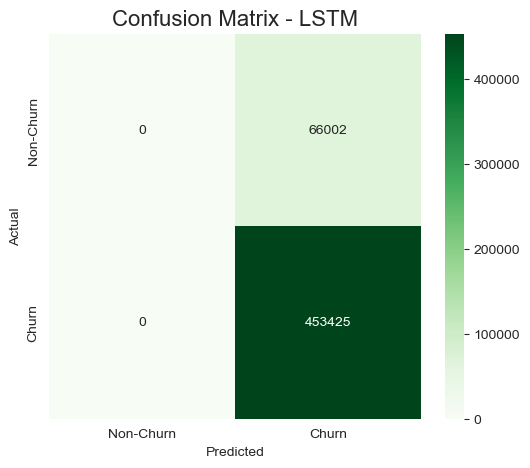

In [8]:
# --- CELL 8: HUẤN LUYỆN VÀ ĐÁNH GIÁ LSTM VỚI PYTORCH ---

X_train_tensor = torch.tensor(X_train_seq.astype(np.float32))
y_train_tensor = torch.tensor(y_train_seq.astype(np.float32)).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_seq.astype(np.float32))
y_test_tensor = torch.tensor(y_test_seq.astype(np.float32)).unsqueeze(1)

class ChurnDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(ChurnDataset(X_train_tensor, y_train_tensor), batch_size=256, shuffle=True)
test_loader = DataLoader(ChurnDataset(X_test_tensor, y_test_tensor), batch_size=256, shuffle=False)

class LSTMChurn(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.3):
        super(LSTMChurn, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_lstm = LSTMChurn(input_size=len(features), hidden_size=64).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

print(f"Bắt đầu huấn luyện LSTM trên thiết bị: {device.upper()}...")
num_epochs = 5
for epoch in range(num_epochs):
    model_lstm.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model_lstm(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

print("\nĐánh giá mô hình LSTM...")
model_lstm.eval()
all_probs_lstm, all_labels_lstm = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model_lstm(batch_X.to(device))
        all_probs_lstm.extend(outputs.cpu().numpy())
        all_labels_lstm.extend(batch_y.cpu().numpy())

y_proba_lstm = np.array(all_probs_lstm)
y_pred_lstm = (y_proba_lstm > 0.5).astype(int)
y_true_lstm = np.array(all_labels_lstm)

print("\n--- 📊 KẾT QUẢ LSTM ---")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=['Non-Churn (0)', 'Churn (1)']))
roc_auc_lstm = roc_auc_score(y_true_lstm, y_proba_lstm)
f1_lstm = f1_score(y_true_lstm, y_pred_lstm)
print(f"🚀 F1-Score: {f1_lstm:.4f}")
print(f"🚀 ROC AUC Score: {roc_auc_lstm:.4f}")

plt.figure(figsize=(6, 5))
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.title('Confusion Matrix - LSTM', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Chuẩn bị dữ liệu cho N-HiTS...
Mỗi user cần có ít nhất 5 tháng dữ liệu trong tập train để được huấn luyện.


Seed set to 42


Tổng số user trong tập train ban đầu: 11839964
Số user có đủ dữ liệu để huấn luyện: 436610

Bắt đầu huấn luyện N-HiTS (chế độ tối ưu)...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.499     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


✅ Huấn luyện N-HiTS hoàn tất.

Bắt đầu dự báo...


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


--- 📊 KẾT QUẢ N-HITS (CHO BÀI TOÁN CHURN) ---
               precision    recall  f1-score   support

Non-Churn (0)       0.33      0.12      0.17     48236
    Churn (1)       0.86      0.96      0.91    276437

     accuracy                           0.83    324673
    macro avg       0.60      0.54      0.54    324673
 weighted avg       0.78      0.83      0.80    324673

🚀 F1-Score: 0.9075
🚀 ROC AUC Score: 0.4037


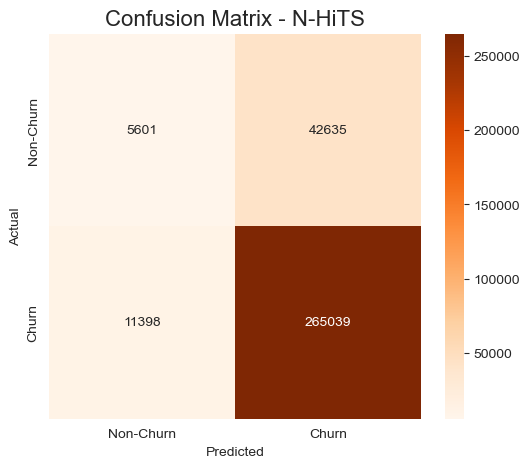

In [16]:
# --- CELL 9 (PHIÊN BẢN HUẤN LUYỆN TỐI ƯU) ---
# HUẤN LUYỆN VÀ ĐÁNH GIÁ N-HITS VỚI HIỆU SUẤT TỐT NHẤT

print("Chuẩn bị dữ liệu cho N-HiTS...")

df_nhits_data = df_processed[['user_id', 'month', 'purchase_count', 'churn']].copy()
df_nhits_data.columns = ['unique_id', 'ds', 'y', 'churn']

train_nhits_df_full = df_nhits_data[df_nhits_data['ds'] < last_month]
test_nhits_df = df_nhits_data[df_nhits_data['ds'] == last_month]

# === BƯỚC 1: CẤU HÌNH CÁC THAM SỐ QUAN TRỌNG ===
# Chúng ta sẽ thử với input_size = 3, tức là dùng 3 tháng lịch sử
INPUT_SIZE = 3
H = 1 # Dự báo 1 tháng tới
VAL_SIZE = 1 # Dùng 1 tháng cuối để làm tập validation

# Tính toán số tháng tối thiểu mà một user cần có
MIN_LEN = INPUT_SIZE + H + VAL_SIZE 
print(f"Mỗi user cần có ít nhất {MIN_LEN} tháng dữ liệu trong tập train để được huấn luyện.")


# === BƯỚC 2: LỌC RA NHỮNG USER CÓ ĐỦ DỮ LIỆU ===
user_lengths = train_nhits_df_full.groupby('unique_id').size()
valid_users = user_lengths[user_lengths >= MIN_LEN].index
train_nhits_df = train_nhits_df_full[train_nhits_df_full['unique_id'].isin(valid_users)]

print(f"Tổng số user trong tập train ban đầu: {train_nhits_df_full['unique_id'].nunique()}")
print(f"Số user có đủ dữ liệu để huấn luyện: {len(valid_users)}")


# === BƯỚC 3: CẤU HÌNH MÔ HÌNH N-HITS ĐỂ TỐI ƯU HIỆU SUẤT ===
# Bật lại Early Stopping và tinh chỉnh các tham số khác
# Bạn có thể thử nghiệm thay đổi các giá trị này để tìm kết quả tốt hơn
model_nhits = NHITS(
    h=H,
    input_size=INPUT_SIZE,
    max_steps=1000,              # Tăng số bước tối đa
    learning_rate=0.001,           # Tốc độ học
    n_pool_kernel_size=[2, 2, 2],  # Cấu trúc của các khối pooling
    n_freq_downsample=[2, 2, 1],   # Cấu trúc của các khối downsampling tần số
    early_stop_patience_steps=10, # Bật lại early stopping với patience = 10
    random_seed=42
)

fcst = NeuralForecast(models=[model_nhits], freq='MS')


# === BƯỚC 4: HUẤN LUYỆN MÔ HÌNH ===
print("\nBắt đầu huấn luyện N-HiTS (chế độ tối ưu)...")
# Thêm val_size=VAL_SIZE để bật validation set
fcst.fit(df=train_nhits_df[['unique_id', 'ds', 'y']], val_size=VAL_SIZE)
print("✅ Huấn luyện N-HiTS hoàn tất.")


# === BƯỚC 5: DỰ BÁO VÀ ĐÁNH GIÁ ===
print("\nBắt đầu dự báo...")
predictions_nhits = fcst.predict()
predictions_nhits = predictions_nhits.reset_index()

# Lọc tập test chỉ với những user đã được lọc để huấn luyện (để so sánh công bằng)
test_nhits_df_filtered = test_nhits_df[test_nhits_df['unique_id'].isin(valid_users)]

merged_test_nhits = pd.merge(test_nhits_df_filtered, predictions_nhits, on='unique_id', how='left')
merged_test_nhits['NHITS'] = merged_test_nhits['NHITS'].fillna(0)

# Gán cột dự đoán vào DataFrame để các cell sau có thể sử dụng
y_pred_nhits = (merged_test_nhits['NHITS'] <= 0.5).astype(int)
merged_test_nhits['churn_pred_nhits'] = y_pred_nhits


# === BƯỚC 6: BÁO CÁO KẾT QUẢ ===
print("\n--- 📊 KẾT QUẢ N-HITS (CHO BÀI TOÁN CHURN) ---")
if not merged_test_nhits.empty and 'churn' in merged_test_nhits.columns:
    y_true_nhits = merged_test_nhits['churn']
    y_proba_nhits = 1 / (1 + np.exp(-merged_test_nhits['NHITS']))
    
    print(classification_report(y_true_nhits, y_pred_nhits, target_names=['Non-Churn (0)', 'Churn (1)']))
    roc_auc_nhits = roc_auc_score(y_true_nhits, y_proba_nhits)
    f1_nhits = f1_score(y_true_nhits, y_pred_nhits)
    print(f"🚀 F1-Score: {f1_nhits:.4f}")
    print(f"🚀 ROC AUC Score: {roc_auc_nhits:.4f}")

    plt.figure(figsize=(6, 5))
    cm_nhits = confusion_matrix(y_true_nhits, y_pred_nhits)
    sns.heatmap(cm_nhits, annot=True, fmt='d', cmap='Oranges', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
    plt.title('Confusion Matrix - N-HiTS', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Tập test cho N-HiTS rỗng hoặc có lỗi, không thể tạo báo cáo.")
    roc_auc_nhits, f1_nhits = 0.5, 0.0

Tổng hợp kết quả từ 3 mô hình...

Bảng so sánh hiệu suất:
     Model   ROC AUC  F1-Score (Churn)
0  XGBoost  0.754006          0.846920
1     LSTM  0.659644          0.932156
2   N-HiTS  0.403688          0.907495


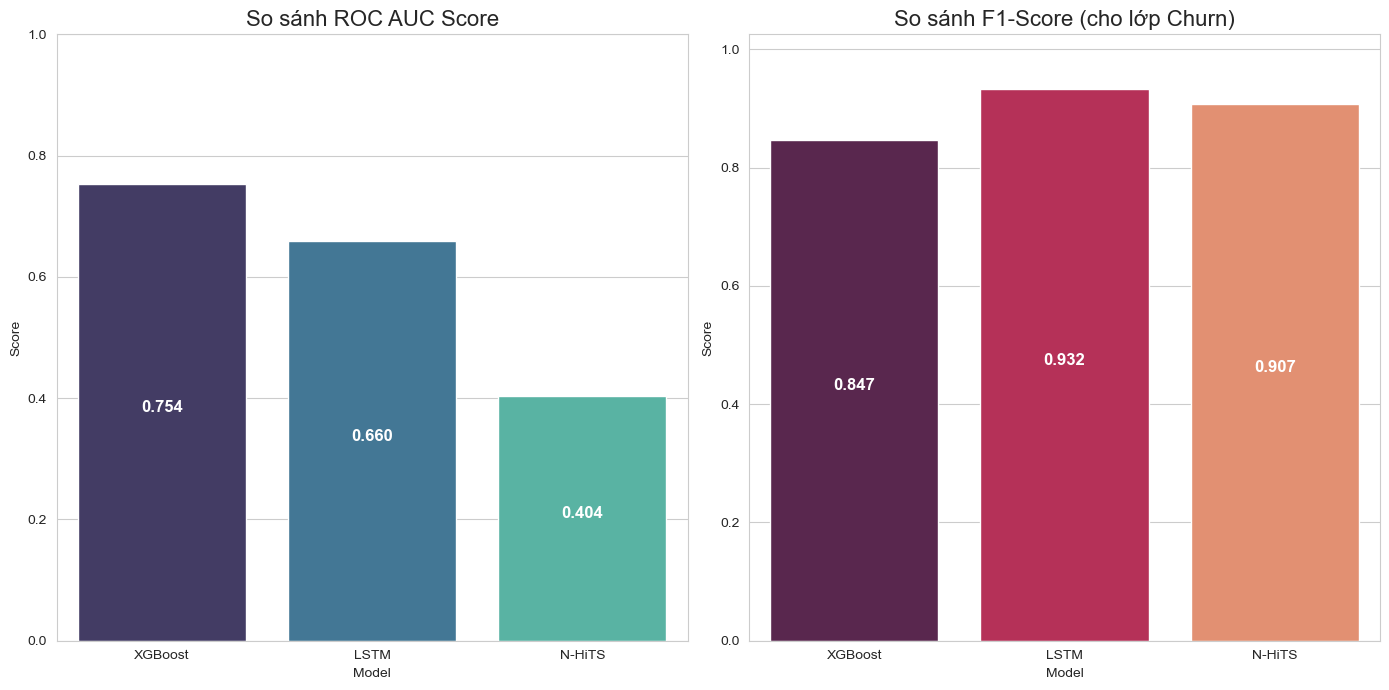

In [17]:
# --- CELL 10: TỔNG KẾT VÀ SO SÁNH KẾT QUẢ ---

print("Tổng hợp kết quả từ 3 mô hình...")

results = pd.DataFrame({
    'Model': ['XGBoost', 'LSTM', 'N-HiTS'],
    'ROC AUC': [roc_auc_xgb, roc_auc_lstm, roc_auc_nhits],
    'F1-Score (Churn)': [f1_xgb, f1_lstm, f1_nhits]
})

results = results.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
print("\nBảng so sánh hiệu suất:")
print(results)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=results, x='Model', y='ROC AUC', palette='mako')
plt.title('So sánh ROC AUC Score', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, max(results['ROC AUC'].max() * 1.1, 1.0))
for i, row in results.iterrows():
    ax1.text(i, row['ROC AUC'] / 2, f"{row['ROC AUC']:.3f}", color='white', ha="center", fontsize=12, weight='bold')

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=results, x='Model', y='F1-Score (Churn)', palette='rocket')
plt.title('So sánh F1-Score (cho lớp Churn)', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, max(results['F1-Score (Churn)'].max() * 1.1, 1.0))
for i, row in results.iterrows():
    ax2.text(i, row['F1-Score (Churn)'] / 2, f"{row['F1-Score (Churn)']:.3f}", color='white', ha="center", fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

Bắt đầu tổng hợp kết quả để trực quan hóa theo chuỗi thời gian...
Tạo sequence kèm theo tháng cho từng user...



Đã tính tỷ lệ churn thực tế.
Đã tính tỷ lệ churn dự báo của XGBoost.
Đã tính tỷ lệ churn dự báo của LSTM.
Đã tính tỷ lệ churn dự báo của N-HiTS.

✅ Hoàn tất! Đang hiển thị biểu đồ so sánh cuối cùng.


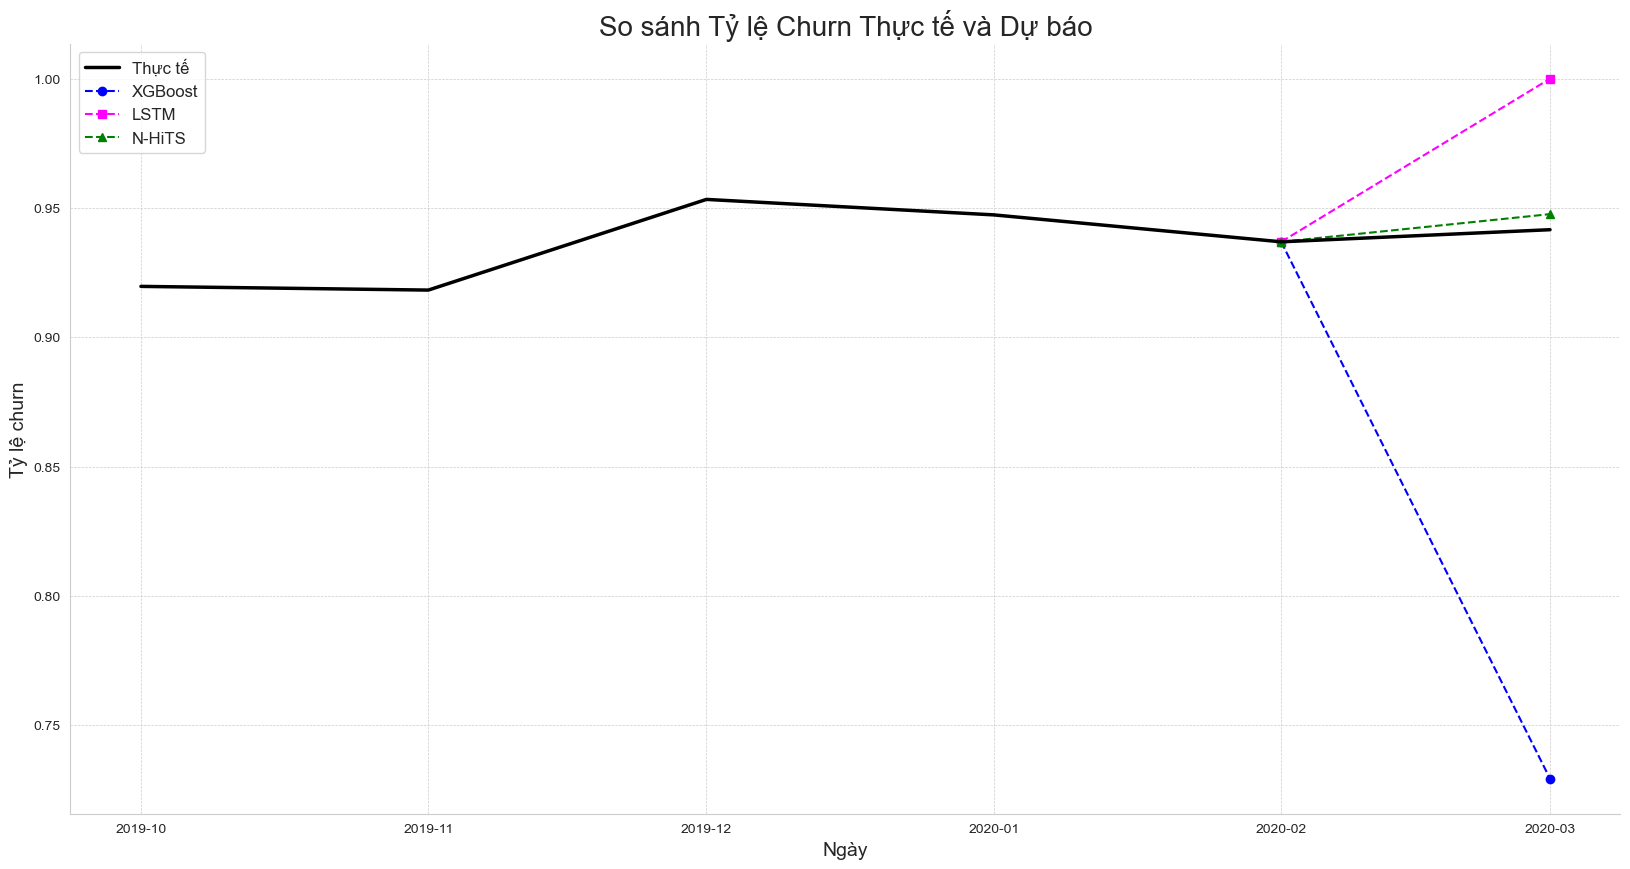

In [18]:
# --- CELL 11 (PHIÊN BẢN AN TOÀN VÀ CHÍNH XÁC) ---
# TRỰC QUAN HÓA SO SÁNH CUỐI CÙNG THEO THỜI GIAN

print("Bắt đầu tổng hợp kết quả để trực quan hóa theo chuỗi thời gian...")

def create_sequences_with_date(df, features, target, sequence_length=3):
    X_seq, y_seq, month_seq = [], [], []
    user_groups = df.groupby('user_id')
    print("Tạo sequence kèm theo tháng cho từng user...")
    for user_id, group in tqdm(user_groups):
        if len(group) > sequence_length:
            data = group[features].values; labels = group[target].values; months = group['month'].values
            for i in range(len(data) - sequence_length):
                X_seq.append(data[i:i + sequence_length]); y_seq.append(labels[i + sequence_length]); month_seq.append(months[i + sequence_length])
    return np.array(X_seq), np.array(y_seq), np.array(month_seq)

# SỬA LỖI: Dùng df_processed thay vì df_final
X_all_seq, y_all_seq, month_all_seq = create_sequences_with_date(df_processed, features, target, SEQUENCE_LENGTH)

# --- Tính toán tỷ lệ churn cho từng mô hình ---
actual_churn_rate = df_processed.groupby('month')['churn'].mean().reset_index()
actual_churn_rate.rename(columns={'churn': 'Thực tế'}, inplace=True)
print("\nĐã tính tỷ lệ churn thực tế.")

xgb_results_df = test_df[['month']].copy()
xgb_results_df['XGBoost'] = y_pred_xgb
xgb_predicted_rate = xgb_results_df.groupby('month')['XGBoost'].mean().reset_index()
print("Đã tính tỷ lệ churn dự báo của XGBoost.")

test_indices = np.where(pd.to_datetime(month_all_seq) == last_month)[0]
if len(test_indices) > 0:
    X_lstm_final_test = torch.tensor(X_all_seq[test_indices].astype(np.float32)).to(device)
    model_lstm.eval()
    with torch.no_grad():
        lstm_preds_for_viz = model_lstm(X_lstm_final_test).cpu().numpy()
    lstm_results_df = pd.DataFrame({'month': last_month, 'LSTM': (lstm_preds_for_viz.flatten() > 0.5).astype(int)})
    lstm_predicted_rate = lstm_results_df.groupby('month')['LSTM'].mean().reset_index()
    print("Đã tính tỷ lệ churn dự báo của LSTM.")
else:
    lstm_predicted_rate = pd.DataFrame(columns=['month', 'LSTM'])
    print("Cảnh báo: Không có đủ dữ liệu để tạo sequence cho LSTM trên tập test thời gian.")

# SỬA LỖI: Truy cập đúng tên cột 'ds_x' và 'churn_pred_nhits'
if 'ds_x' in merged_test_nhits.columns and 'churn_pred_nhits' in merged_test_nhits.columns and not merged_test_nhits.empty:
    nhits_results_df = merged_test_nhits[['ds_x', 'churn_pred_nhits']].copy()
    nhits_results_df.rename(columns={'ds_x': 'month', 'churn_pred_nhits': 'N-HiTS'}, inplace=True)
    nhits_predicted_rate = nhits_results_df.groupby('month')['N-HiTS'].mean().reset_index()
    print("Đã tính tỷ lệ churn dự báo của N-HiTS.")
else:
    nhits_predicted_rate = pd.DataFrame(columns=['month', 'N-HiTS'])
    print("Cảnh báo: Không thể tính toán tỷ lệ churn dự báo cho N-HiTS.")

# --- Gộp tất cả dữ liệu và vẽ biểu đồ ---
final_plot_df = actual_churn_rate.set_index('month')
plot_data_list = [xgb_predicted_rate, lstm_predicted_rate, nhits_predicted_rate]
for df in plot_data_list:
    if not df.empty:
        df = df.set_index('month')
        final_plot_df = final_plot_df.merge(df, on='month', how='left')

if len(final_plot_df) > 1 and last_month in final_plot_df.index:
    last_actual_month_index = final_plot_df.index.get_loc(last_month) - 1
    if last_actual_month_index >= 0:
        last_actual_value = final_plot_df['Thực tế'].iloc[last_actual_month_index]
        for model_col in ['XGBoost', 'LSTM', 'N-HiTS']:
            if model_col in final_plot_df.columns:
                final_plot_df.loc[final_plot_df.index[last_actual_month_index], model_col] = last_actual_value

plt.figure(figsize=(20, 10))
plt.plot(final_plot_df.index, final_plot_df['Thực tế'], label='Thực tế', color='black', linewidth=2.5, zorder=5)
for model_col, color, marker in zip(['XGBoost', 'LSTM', 'N-HiTS'], ['blue', 'magenta', 'green'], ['o', 's', '^']):
    if model_col in final_plot_df.columns:
         plt.plot(final_plot_df.index, final_plot_df[model_col], label=model_col, color=color, marker=marker, linestyle='--')

plt.title('So sánh Tỷ lệ Churn Thực tế và Dự báo', fontsize=20)
plt.xlabel('Ngày', fontsize=14); plt.ylabel('Tỷ lệ churn', fontsize=14)
plt.legend(fontsize=12, loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().spines['top'].set_visible(False); plt.gca().spines['right'].set_visible(False)
print("\n✅ Hoàn tất! Đang hiển thị biểu đồ so sánh cuối cùng.")
plt.show()